In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
# http://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost
import sys
import os

import pandas as pd
import numpy as np

# # Remote Data Access
# import pandas_datareader.data as web
# import datetime
# # reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

C:\Users\LOMO\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
#Read the data
#美国消费者信心指数
Sentiment = 'data/sentiment.csv'
Sentiment = pd.read_csv(Sentiment, index_col=0, parse_dates=[0]) #index_col=0表示CSV文件中第0列作为index

In [7]:
Sentiment.head()

,UMCSENT
DATE,
2000-01-01,112.00000
2000-02-01,111.30000
2000-03-01,107.10000
2000-04-01,109.20000
2000-05-01,110.70000


In [8]:
# Select the series from 2005 - 2016
sentiment_short = Sentiment.loc['2005':'2016']

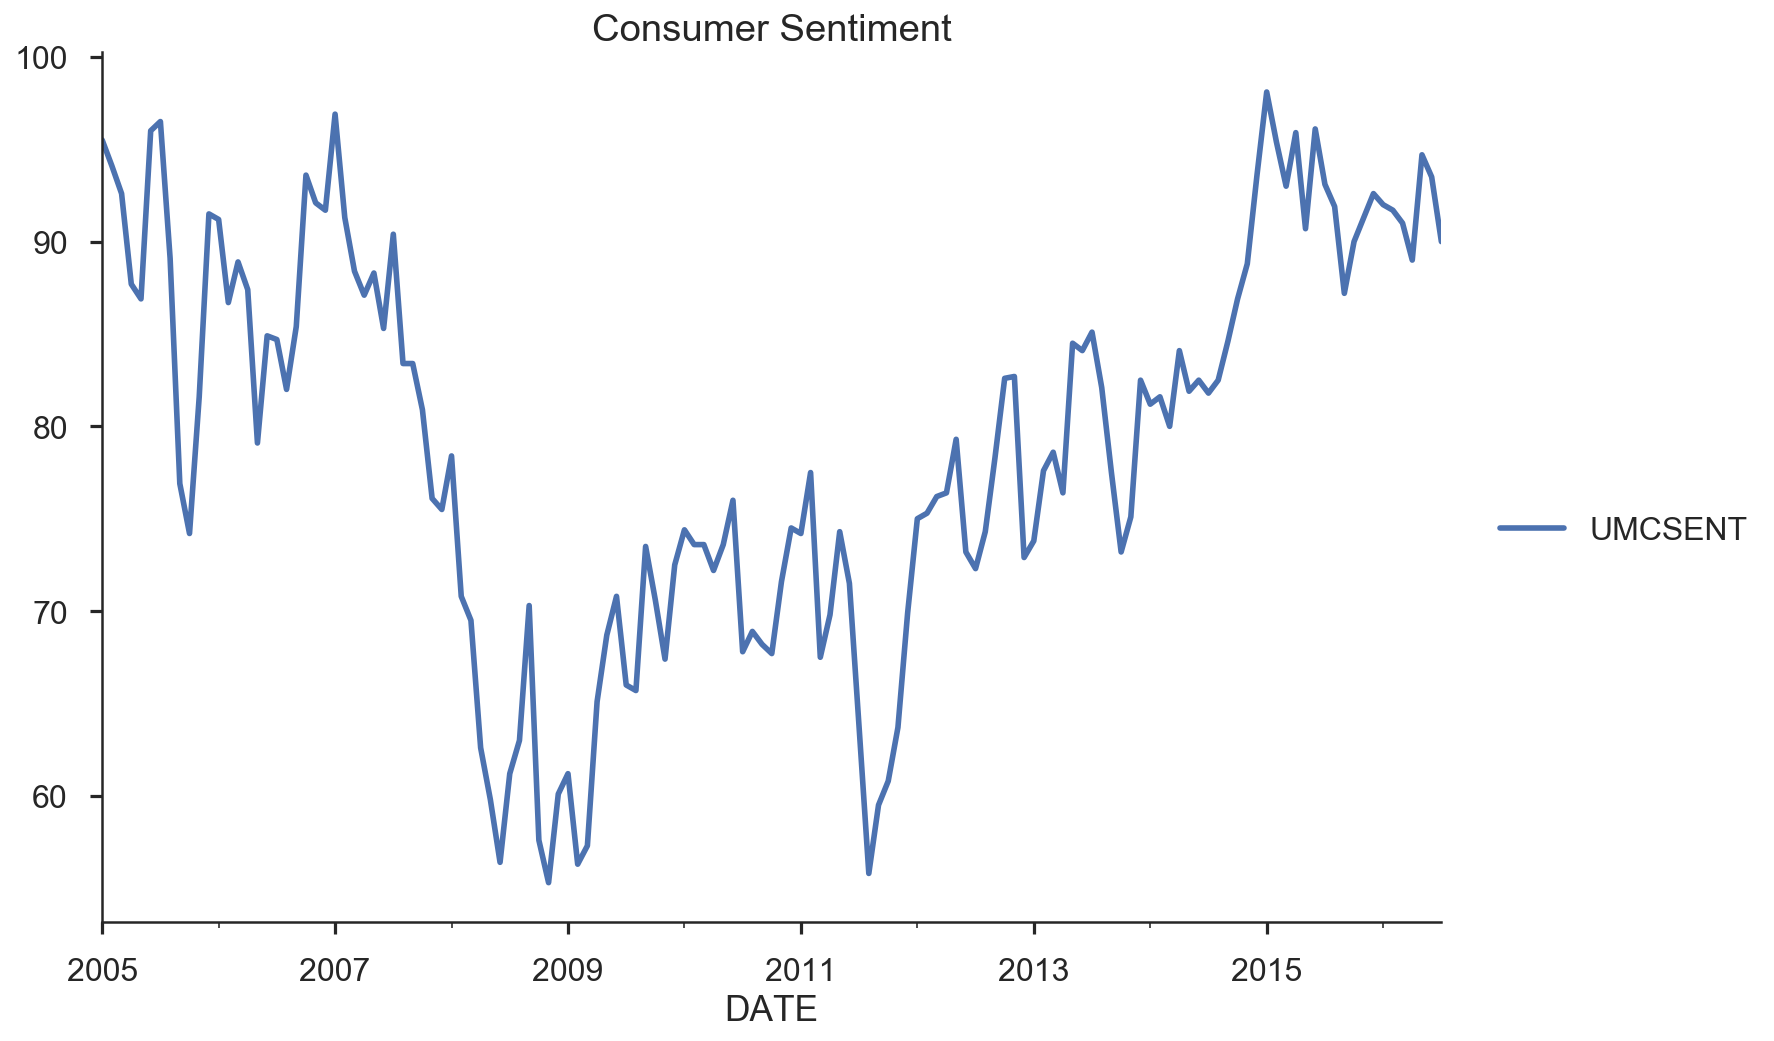

In [9]:
sentiment_short.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Consumer Sentiment")
sns.despine()

C:\Users\LOMO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\LOMO\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000232A21C1B38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000232A21A0940>], dtype=object)

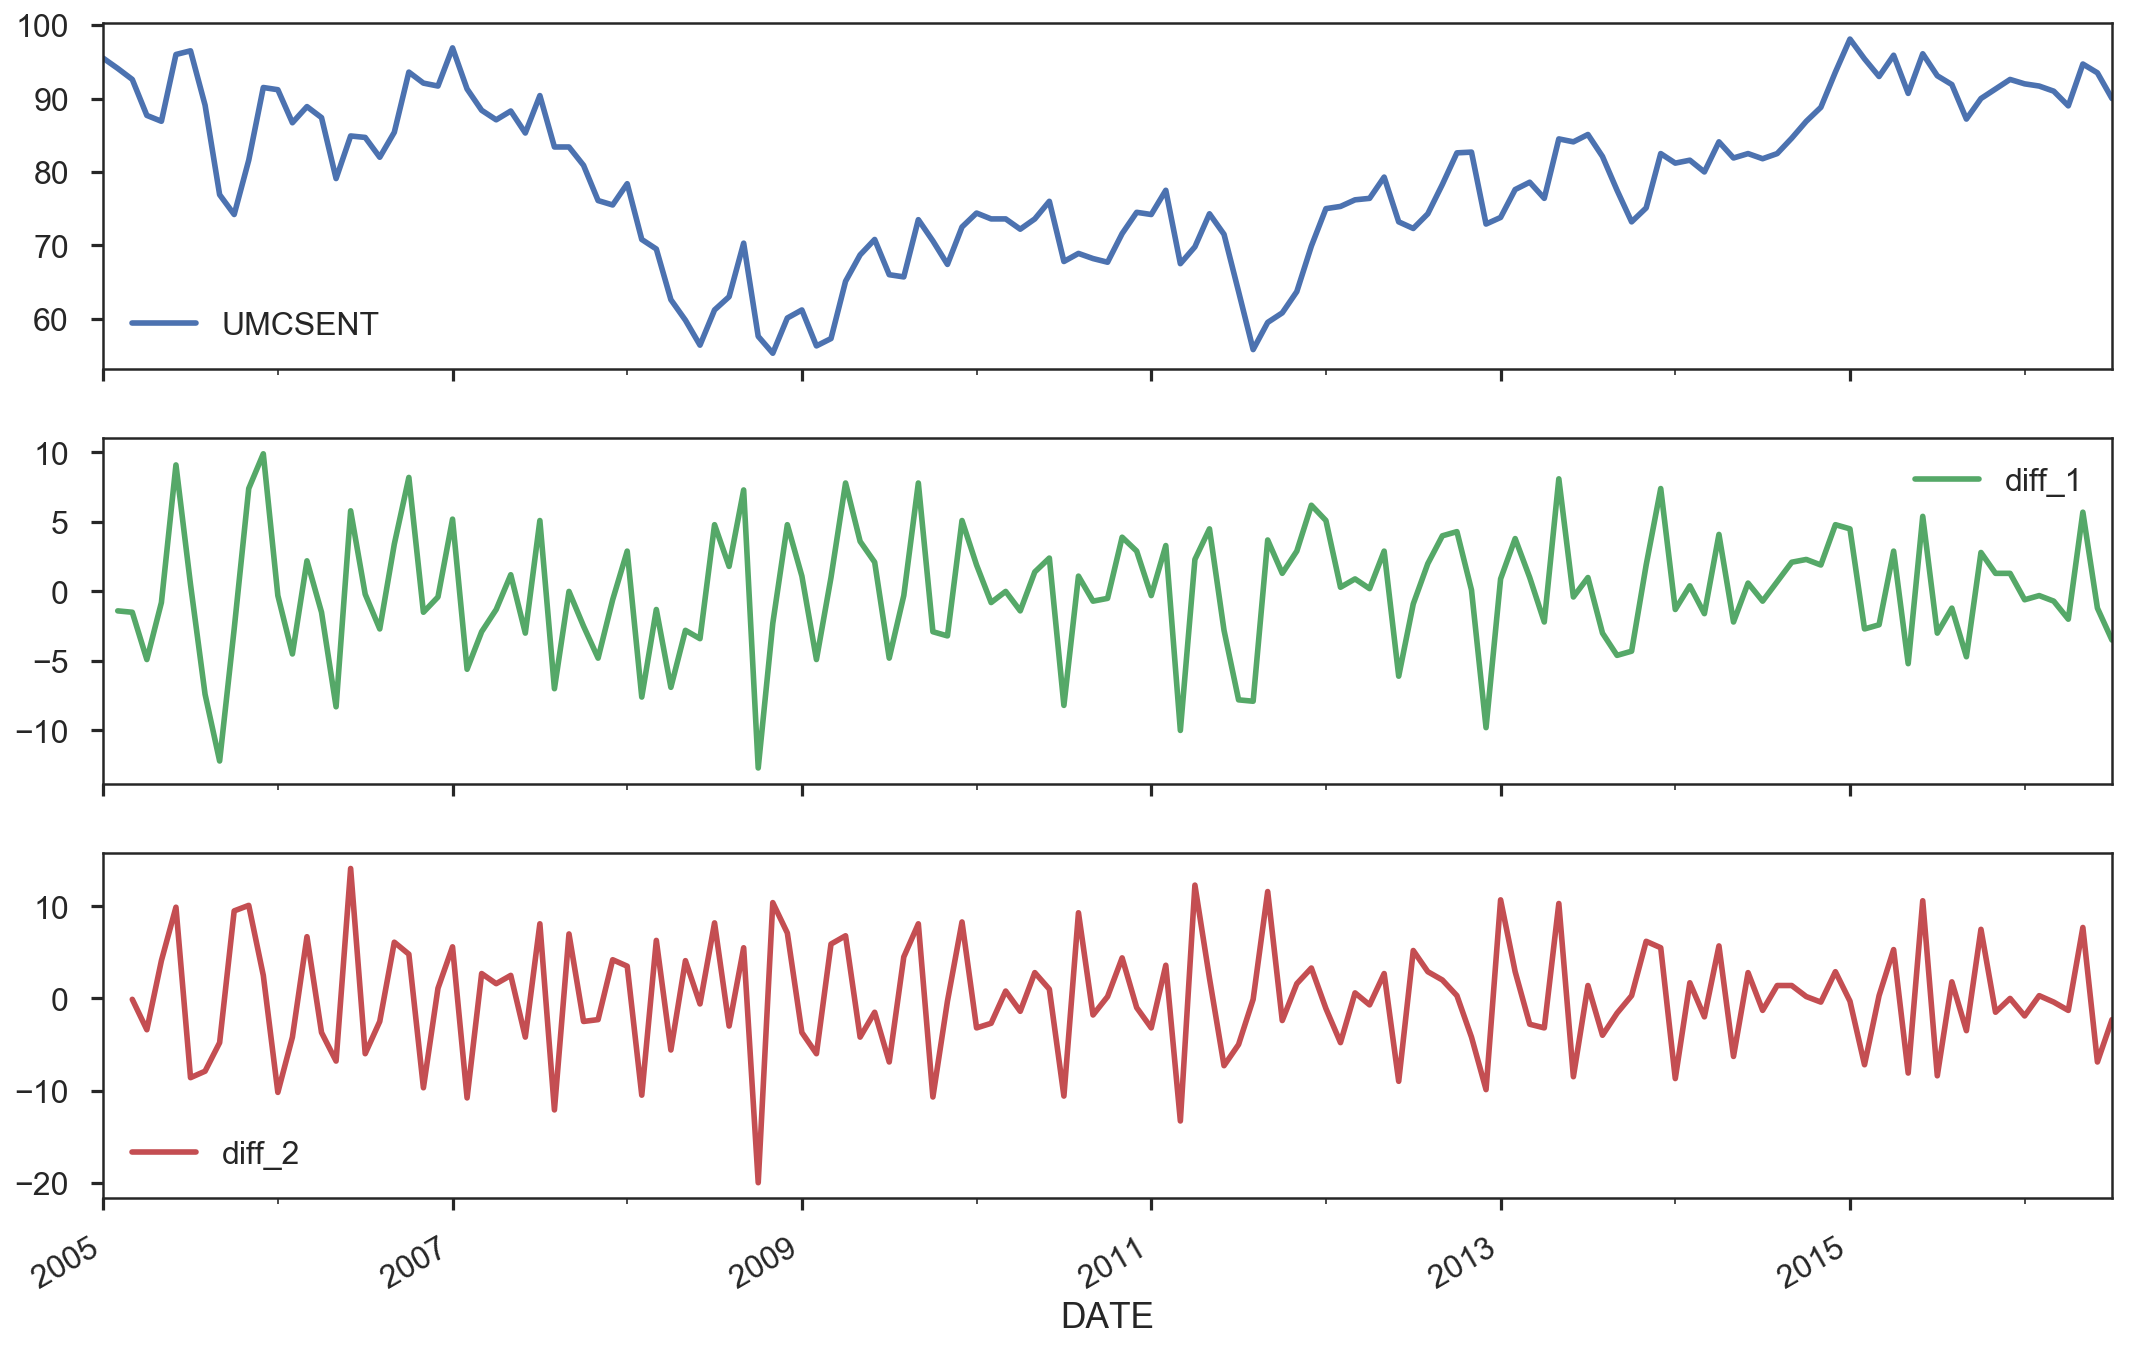

In [11]:
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)

sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)

sentiment_short.plot(subplots=True, figsize=(18, 12))

In [12]:
del sentiment_short['diff_2']
del sentiment_short['diff_1']
print (type(sentiment_short))
sentiment_short.head()

<class 'pandas.core.frame.DataFrame'>


,UMCSENT
DATE,
2005-01-01,95.50000
2005-02-01,94.10000
2005-03-01,92.60000
2005-04-01,87.70000
2005-05-01,86.90000


### 画序列ACF和PACF图

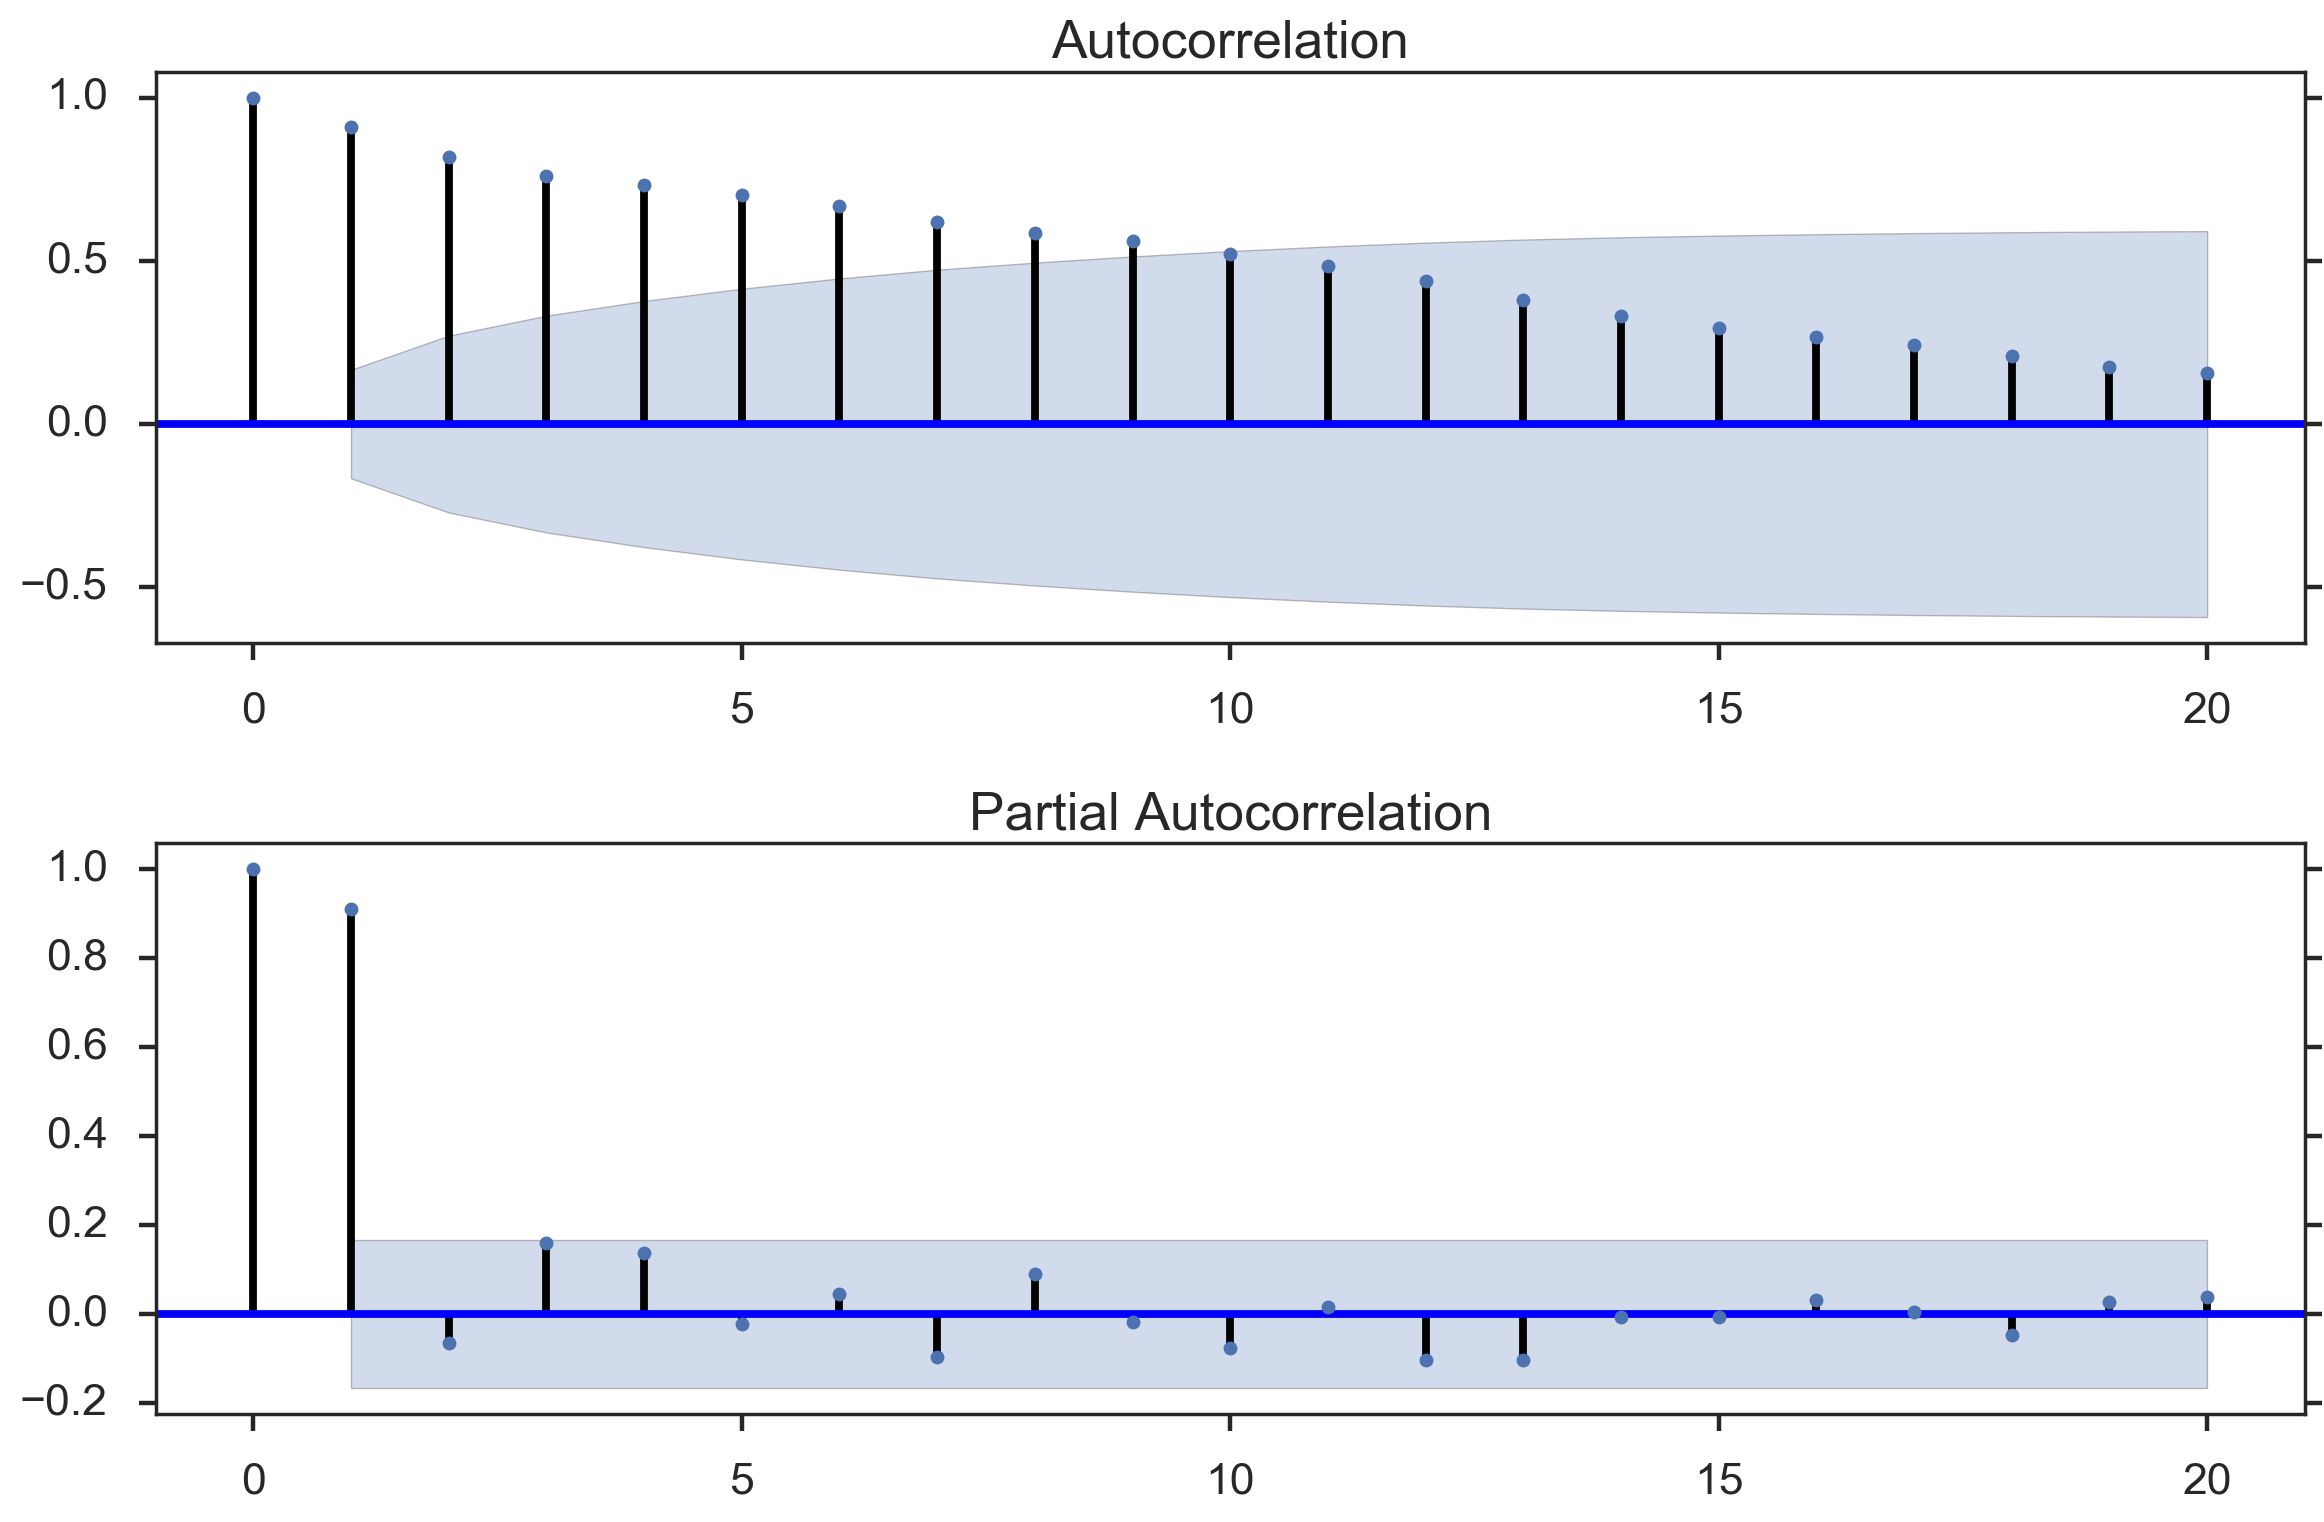

In [71]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

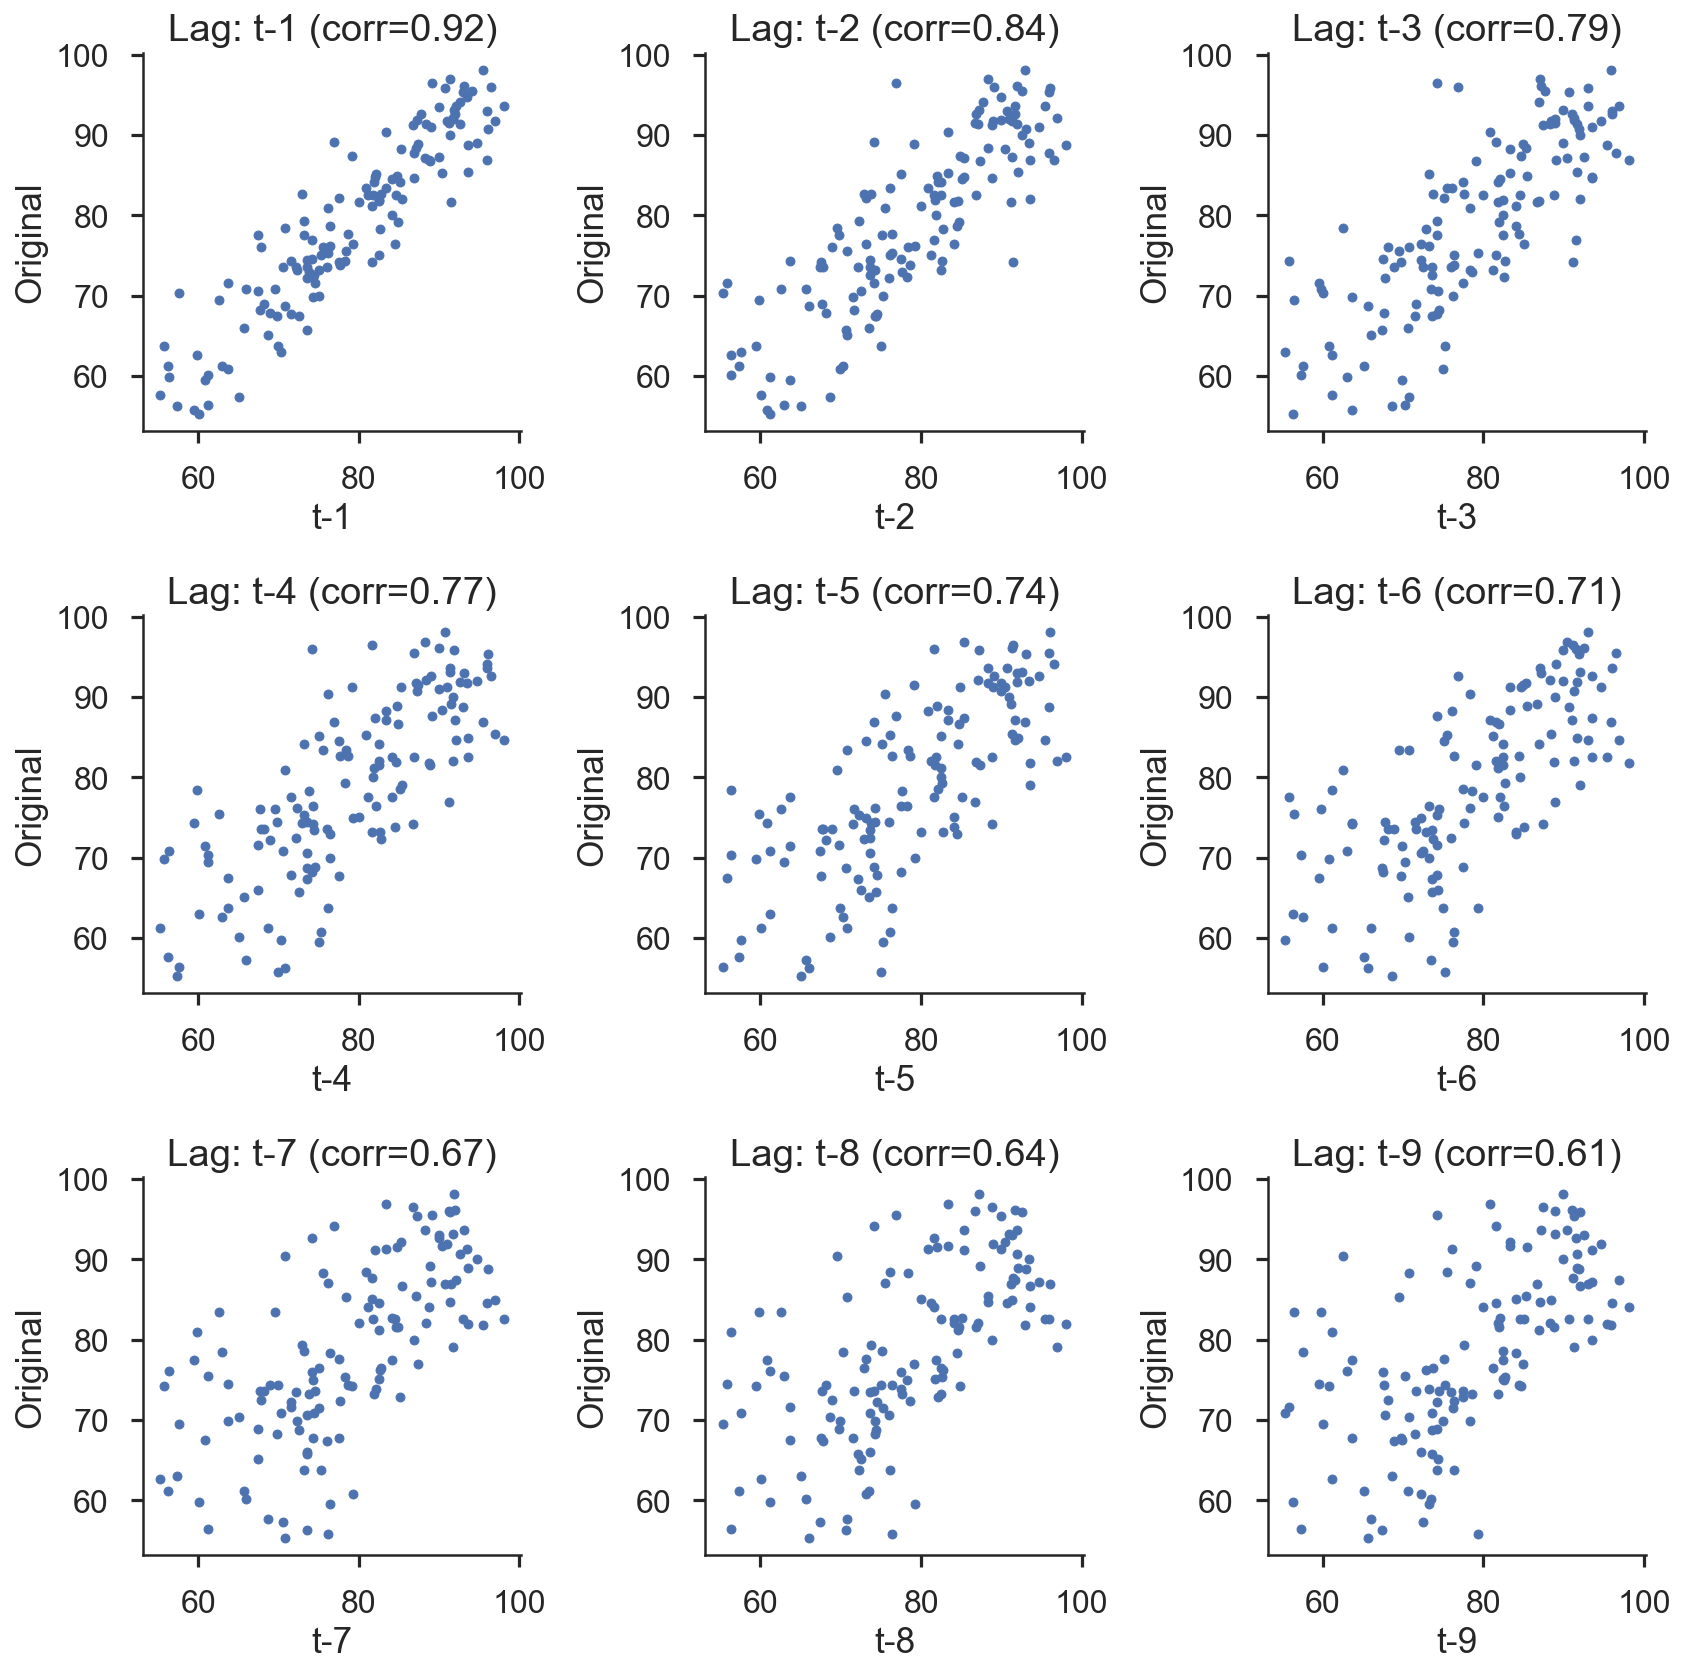

In [13]:
# 散点图也可以表示，更为直观一些

lags=9

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([sentiment_short, sentiment_short.shift(-lag)], axis=1,   #这里传入序列数据
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();

### 模板

In [14]:
# 更直观一些

def tsplot(y, lags=None, title='', figsize=(14, 8)):
   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

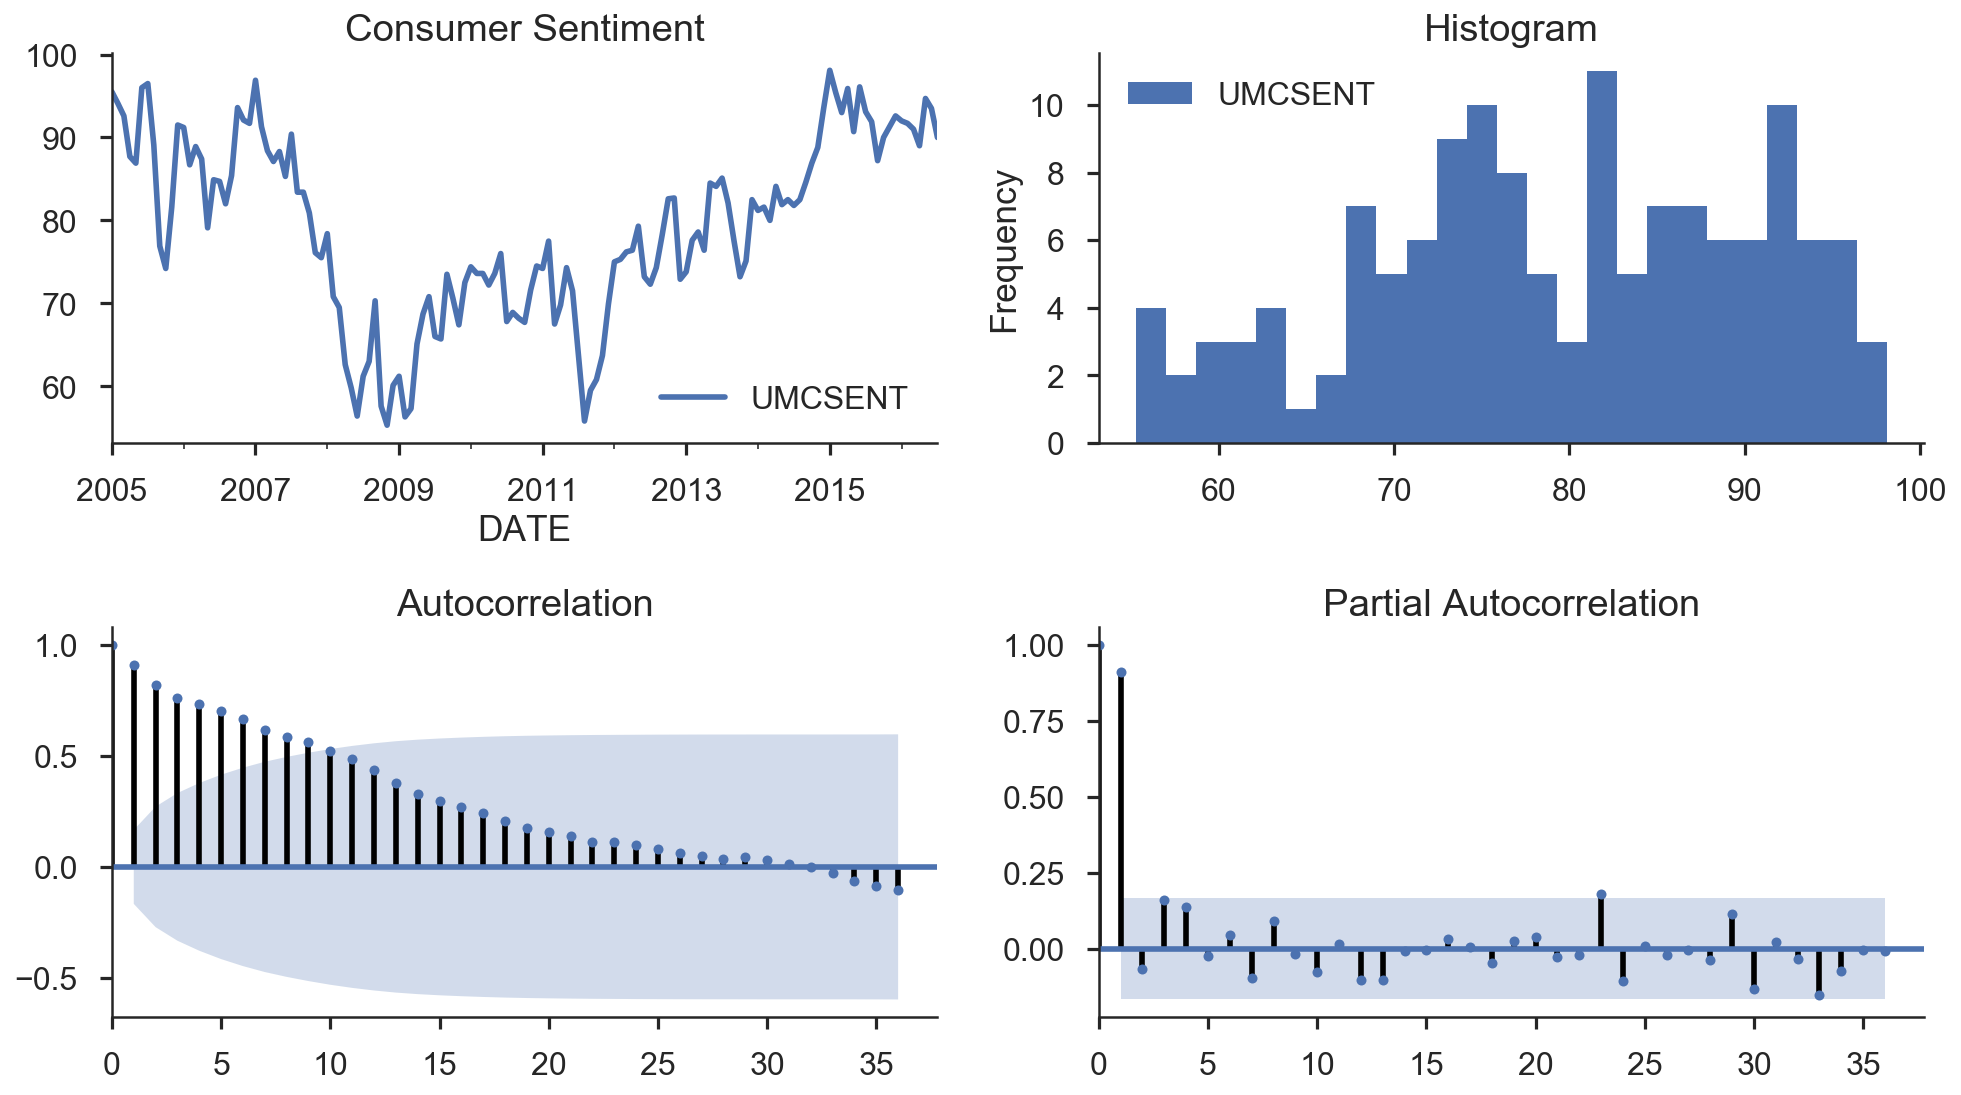

In [15]:
tsplot(sentiment_short, title='Consumer Sentiment', lags=36);